In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns

In [4]:
import tensorflow as tf
import nltk
nltk.download('stopwords')
nltk.download('punkt')

import re
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Activation,Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten,GlobalMaxPooling1D,Conv1D, Embedding, LSTM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [8]:
movie_review = pd.read_csv("/content/drive/MyDrive/Movie_Reviews_Dataset/IMDB Dataset.csv")

In [9]:
movie_review.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [10]:
movie_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [11]:
movie_review.isnull().sum()

review       0
sentiment    0
dtype: int64

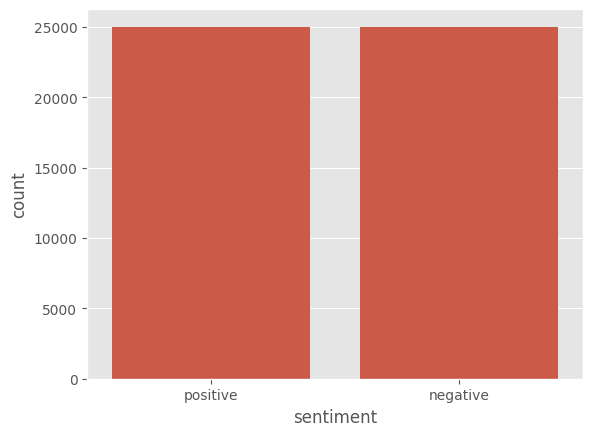

In [12]:
plt.style.use("ggplot")
sns.countplot(data = movie_review, x = movie_review["sentiment"])
plt.show()

In [13]:
movie_review["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

# Data Preprocess

In [14]:
def preprocess_data(sentence):
  stop_words = stopwords.words("english")
  html_tag = re.compile(r'<[^>]+>')
  sentence = sentence.lower()
  # html tagleri silme
  sentence = html_tag.sub('', sentence)
  # noktalama isaretleri ve sayilari silme
  sentence = re.sub('[^a-zA-Z]', ' ', sentence)
  # tek kalan karakterleri silme
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  # birden fazla boşluklari silme
  sentence = re.sub(r'\s+', ' ', sentence)
  # durdurma kelimelerini silme
  pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
  sentence = pattern.sub('', sentence)

  return sentence

In [15]:
x = []
sentences = list(movie_review["review"])
for sen in sentences:
  x.append(preprocess_data(sen))

In [16]:
x[2]

'thought wonderful way spend time hot summer weekend sitting air conditioned theater watching light hearted comedy plot simplistic dialogue witty characters likable even well bread suspected serial killer may disappointed realize match point risk addiction thought proof woody allen still fully control style many us grown love laughed one woody comedies years dare say decade never impressed scarlet johanson managed tone sexy image jumped right average spirited young woman may crown jewel career wittier devil wears prada interesting superman great comedy go see friends '

In [17]:
# negatif yorumları 0 pozitif yorumları 1 yapıyoruz
y = movie_review["sentiment"]
y = np.array(y.map({'negative' : 0, 'positive': 1}))
y[:5]

array([1, 1, 1, 0, 1])

In [18]:
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
exclude = set(string.punctuation)

#for positive sentiments
df_pos = movie_review[movie_review["sentiment"]=="positive"]

#for only unigrams
token_list=[]

for i,r in df_pos.iterrows():
    text=''.join(ch for ch in x[i])
    tokens=word_tokenize(text)
    tokens=[tok for tok in tokens]
    token_list.extend(tokens)

frequencies=Counter(token_list)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])

### Pozitif yorumlarda en çok geçen kelimeler

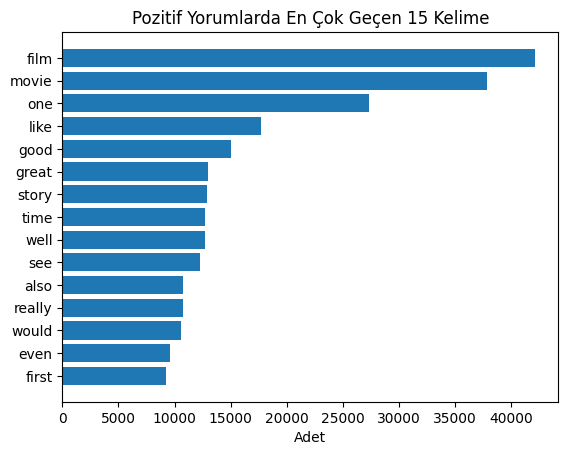

In [19]:
plt.rcdefaults()
fig, ax = plt.subplots()


ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()
ax.set_xlabel('Adet')
ax.set_title('Pozitif Yorumlarda En Çok Geçen 15 Kelime')

plt.show()

In [20]:
exclude = set(string.punctuation)

#for negative review
df_neg = movie_review[movie_review["sentiment"]=="negative"]

#for only unigrams
neg_token_list=[]

for i,r in df_neg.iterrows():
    text=''.join(ch for ch in x[i])
    tokens=word_tokenize(text)
    tokens=[tok for tok in tokens]
    neg_token_list.extend(tokens)

frequencies_neg=Counter(neg_token_list)
frequencies_sorted_neg=sorted(frequencies_neg.items(), key=lambda k: k[1],reverse=True)
top_15_neg=dict(frequencies_sorted_neg[0:15])

### Negatif yorumlarda en çok geçen kelimeler

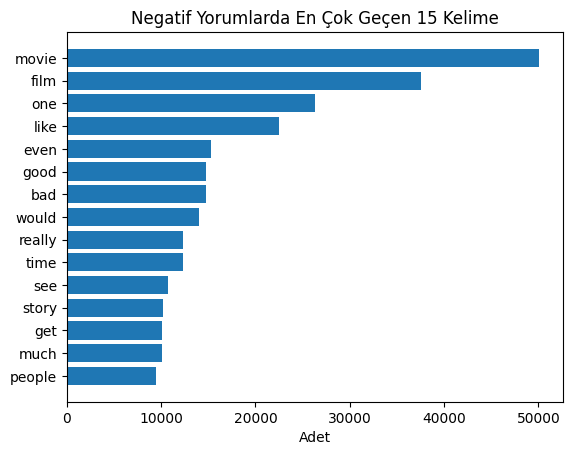

In [21]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
ngram_neg = top_15_neg.keys()
y_neg = np.arange(len(ngram_neg))
performance_neg = top_15_neg.values()


ax.barh(y_neg, performance_neg, align='center')
ax.set_yticks(y_neg)
ax.set_yticklabels(ngram_neg)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Adet')
ax.set_title('Negatif Yorumlarda En Çok Geçen 15 Kelime')

plt.show()

### Pozitif yorumlarda yan yana en çok geçen kelimeler

In [22]:
from nltk.util import ngrams
bigrams=list(ngrams(token_list,2))
frequencies=Counter(bigrams)
frequencies_sorted=sorted(frequencies.items(), key=lambda k: k[1],reverse=True)
top_15=dict(frequencies_sorted[0:15])

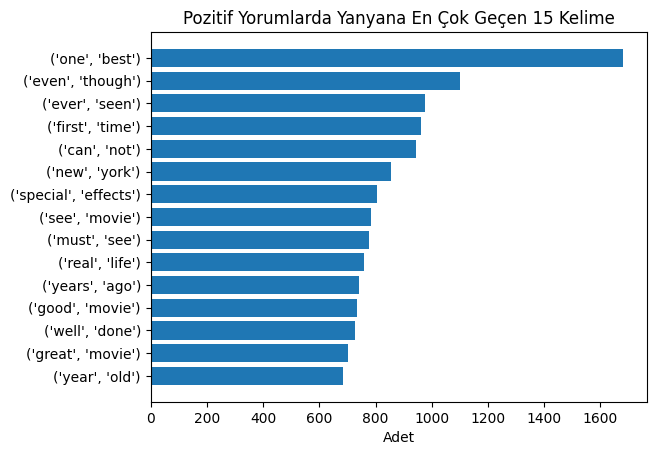

In [23]:
plt.rcdefaults()
fig, ax = plt.subplots()

ngram = top_15.keys()
y_pos = np.arange(len(ngram))
performance = top_15.values()


ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram)
ax.invert_yaxis()
ax.set_xlabel('Adet')
ax.set_title('Pozitif Yorumlarda Yanyana En Çok Geçen 15 Kelime')

plt.show()

In [24]:
bigrams_neg=list(ngrams(neg_token_list,2))
frequencies_neg=Counter(bigrams_neg)
frequencies_sorted_neg=sorted(frequencies_neg.items(), key=lambda k: k[1],reverse=True)
top_15_neg=dict(frequencies_sorted_neg[0:15])

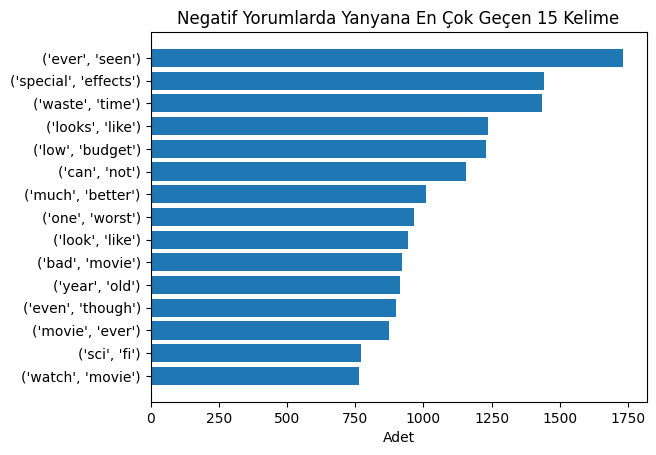

In [25]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
ngram_neg = top_15_neg.keys()
y_pos = np.arange(len(ngram_neg))
performance_neg = top_15_neg.values()

ax.barh(y_pos, performance_neg, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(ngram_neg)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Adet')
ax.set_title('Negatif Yorumlarda Yanyana En Çok Geçen 15 Kelime')

plt.show()

In [28]:
len(x)

50000

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(x)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [34]:
y_pred = nb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8665


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4961
           1       0.88      0.85      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

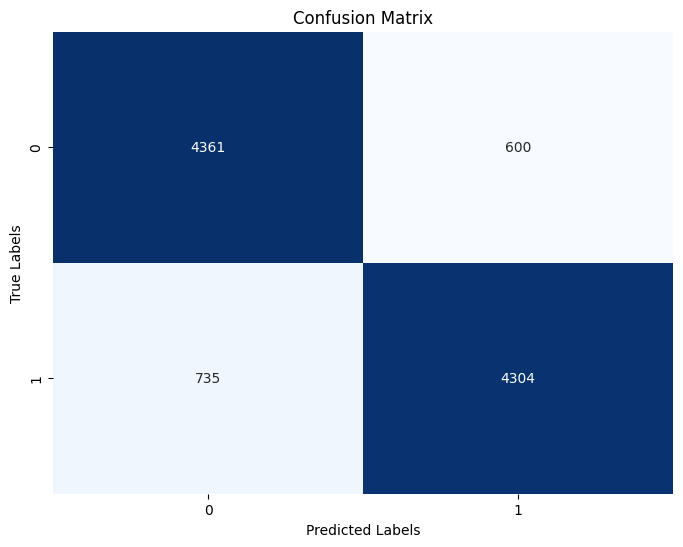

In [39]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()